车牌号码识别

In [1]:
import os
import os.path
import shutil
import cv2
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
def imshow(img):
    s=img.shape
    if len(s)>2:
        b,g,r=cv2.split(img)
        img=cv2.merge([r,g,b])
    else:
        img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
#PICFILE='./data/20170220_141247.jpg'  #AE2E62
PICFILE='./data/20170220_141344.jpg'  #AFP963
#PICFILE='./data/20170220_141339.jpg'  # F-ASE9[1]0
#PICFILE='./data/20170220_141435.jpg'  #AFL558
#PICFILE='./data/20170221_141116.jpg'  #L-AYY206


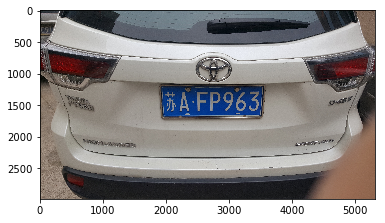

In [4]:
img = cv2.imread(PICFILE)
#img=cv2.resize(img,(int(img.shape[1]/10),int(img.shape[0]/10)))
imshow(img)

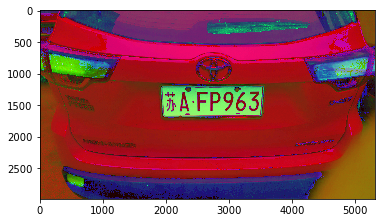

In [5]:
colorImage = img.copy()
_colorImage = img.copy()
hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
imshow(hsv)

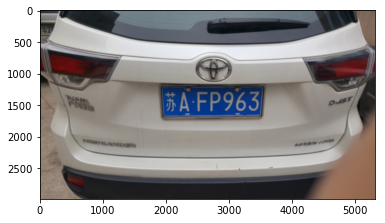

In [6]:
#高斯模糊
img = cv2.GaussianBlur(img,(51,51),0)
imshow(img)

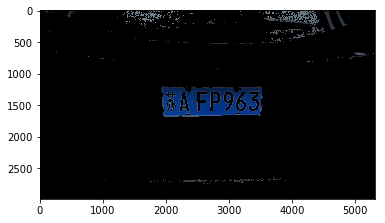

In [7]:
#阈值和掩模
lower=np.array([100,50,50])
upper=np.array([140,255,255])
mask=cv2.inRange(hsv,lower,upper)
res=cv2.bitwise_and(img,img,mask=mask)
imshow(res)

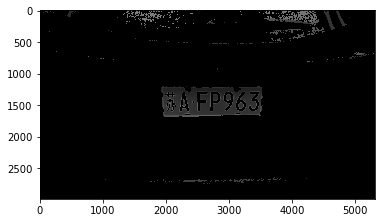

In [8]:
#灰度化
gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
imshow(gray)

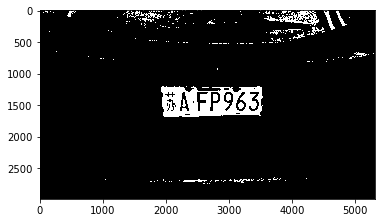

In [9]:
#二值化
ret,thresh = cv2.threshold(gray,100,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(thresh)

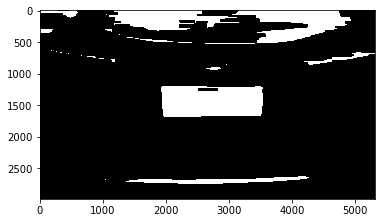

In [10]:
#闭操作
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(171, 31))
imgclose = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
imshow(imgclose)

In [11]:
#轮廓
(contours, _) = cv2.findContours(imgclose.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [12]:
#对轮廓求最小外接矩形，然后验证，不满足条件的淘汰
imgc=imgclose
con=sorted(contours,key=cv2.contourArea,reverse=True)            
ret=[]
for i,c in enumerate(con):
    x,y,w,h=cv2.boundingRect(c)
    ratio=w//h
    if ratio>5 or ratio < 2:
        continue
    if w< 400 or h < 150:
        continue
    ret.append((x,y,w,h))
print len(ret)
#角度判断与旋转
#暂无

2


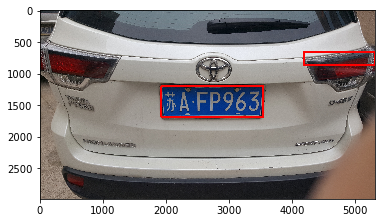

True

In [13]:
#绘制
imgrect = cv2.imread(PICFILE)
for i,r in enumerate(ret):
    x,y,w,h=r
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),30)
imshow(imgrect)    
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgrect)

/home/wang/git/nppic/0.jpg


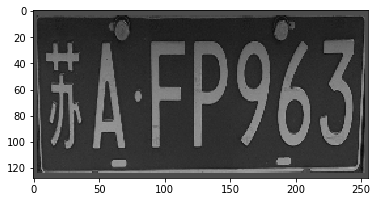

/home/wang/git/nppic/100.jpg


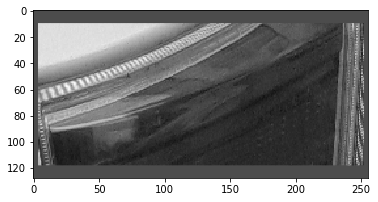

In [26]:
#截取
npjpg=[] #原图
detect=np.ndarray((len(ret),128,256),np.uint8) #检测的图
for i,(x,y,w,h) in enumerate(ret):
    imgr=imgrect[y:y+h,x:x+w]
    npjpg.append(imgr.copy())
    imgray=cv2.cvtColor(imgr,cv2.COLOR_BGR2GRAY)
    imgray=cv2.resize(imgray,(256,128))
    detect[i]=imgray
    fname='/home/wang/git/nppic/{}.jpg'.format(i*100)
    print fname
    cv2.imwrite(fname,imgray)
    imshow(detect[i])

In [28]:
#model
conv=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,padding=1), #layer1, inputs single channel,256*128
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,padding=1), #layer2 inputs 64 channel,128*64
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256,kernel_size=3,padding=1), #layer3 inputs 128 channel,64*32
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256,512,kernel_size=3,padding=1), #layer4 inputs 256 channel,32*16
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512,512,kernel_size=3,padding=1), #layer5 inputs 512 channel,16*8
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
    )

class vgg16train(nn.Module):
    def __init__(self):
        super(vgg16train,self).__init__()
        self.features=conv
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 8 * 4, 4096),                             #connect: layter: inputs 512, 8*4
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 2)
        )
        #initialize_weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

In [16]:
#pytorch folder dataset 以目录区分类别时，类别和索引的映射
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

In [17]:
#classes,class_to_idx=find_classes('/home/wang/git/nppic/nproot')
#print class_to_idx
#{'plate': 1, 'back': 0}

In [29]:
model=vgg16train()
model.cuda()
model.load_state_dict(torch.load('/home/wang/git/anpr/plate.weight'))
print('over')

over


In [27]:
#npjpg#原图
#detect#待检测的图 
data_transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((107.5051,), (3847.1679,)),
                             ])
datas=data_transform(detect)
datas=torch.unsqueeze(datas,1)
datas.size()

torch.Size([2, 1, 128, 256])

In [30]:
data_var=Variable(datas)
data_var=data_var.cuda()
output_var=model(data_var)
_, predicted = torch.max(output_var.data, 1)

In [31]:
output_var.data,predicted

(
  1.4524 -1.5957
  2.7114 -2.8040
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
  0
  0
 [torch.cuda.LongTensor of size 2x1 (GPU 0)])

In [25]:
pred=predicted.cpu().numpy()
npidx=-1
for i,c in enumerate(pred):
    npidx=int(c[0])
    break
assert(npidx>-1)    

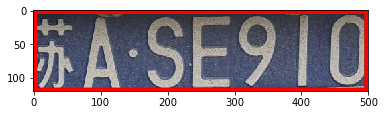

In [746]:
#字符切割
CHARFILE='/home/wang/git/nppic/0.jpg'
charimg=cv2.imread(CHARFILE)
imgchar=cv2.resize(charimg,(500,120))
imshow(imgchar)

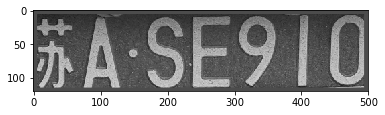

In [747]:
gray_img = cv2.cvtColor(imgchar.copy(),cv2.COLOR_BGR2GRAY)  #灰度
imshow(gray_img)

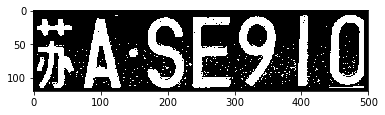

In [748]:
_,threshold_img  = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY) #二值化
imshow(threshold_img)

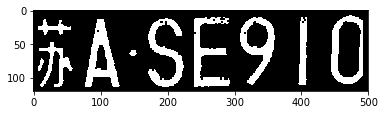

In [749]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3)) #闭操作，先膨胀再腐蚀
eroded = cv2.erode(threshold_img,kernel)
imshow(eroded)

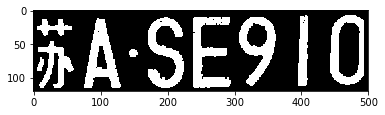

In [750]:
dilated = cv2.dilate(eroded,kernel)
imshow(dilated)

In [751]:
(contours,_) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
con=sorted(contours,key=cv2.contourArea,reverse=True)            
ret=[]
#w:500 h:124
for i,c in enumerate(con):
    x,y,w,h=cv2.boundingRect(c)
    ratio=float(h)/float(w)
    if ratio<1.3 or ratio> 5:
        continue
    if h < 50:
        continue
    ret.append((x,y,w,h))

print len(ret)

6


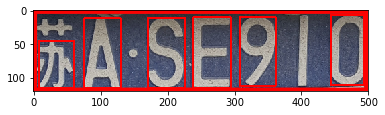

[(444, 7, 50, 104), (308, 10, 54, 102), (76, 12, 55, 103), (239, 10, 56, 105), (171, 11, 55, 104), (8, 46, 53, 69)]


In [752]:
#绘制
imgrect = imgchar.copy()
chars=sorted(ret)  ##根据x值进行排序
chars
for i,r in enumerate(chars):
    x,y,w,h=r
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),2)
imshow(imgrect)    
print ret

In [753]:
#len(ret) == 6
chardatas=np.ndarray((len(chars),1,28,28),np.uint8)
#以二值图像作为复制源
imgcut=threshold_img.copy()
for i,r in enumerate(chars):
    x,y,w,h=r
    print x,y,w,h
    chari=imgcut[y-3:y+h+3,x-3:x+w+3]  #切割
    #处理字母I
    canvas=np.zeros((28,28),np.uint8)    
    if (h//w) > 5:
        wi=int(w*28/h)
        chari=cv2.resize(chari.copy(),(wi,28))
        offset=int((28-wi)/2)
        print offset,wi,chari.shape
        canvas[:,offset:offset+wi]=chari
    else:    
        chari=cv2.resize(chari.copy(),(18,28))    
        canvas[:,5:23]=chari
    chardatas[i][0]=canvas
    fname='/home/wang/git/nppic/char-{}.bmp'.format(i)
    cv2.imwrite(fname,canvas)

8 46 53 69
76 12 55 103
171 11 55 104
239 10 56 105
308 10 54 102
444 7 50 104


In [754]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 34)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))                              #28*28
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #12*12
        x = x.view(-1, 4*4*20)                                                                #8*8
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x) 

In [755]:
#classes,class_to_idx=find_classes('/home/wang/git/nppic/ann/train')
#print class_to_idx
DIGITS='0123456789'
LETTER='ABCDEFGHJKLMNPQRSTUVWXYZ'
CHAR=DIGITS+LETTER
CHARCLASSES=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z']

In [756]:
net=Net()
net.load_state_dict(torch.load('/home/wang/git/anpr/coder.net.weight'))

In [757]:
#chardatas.shape
#mean=72.289
#var=11233.9628
#chardatas=(chardatas-mean)/var

In [759]:
chardatas=np.array(chardatas,np.float)
charimgdata=torch.FloatTensor(chardatas)
outputs = net(Variable(charimgdata))
_, predicted = torch.max(outputs.data, 1)
predicted


 15
 10
 26
 14
  9
  0
[torch.LongTensor of size 6x1]

In [760]:
pred=predicted.numpy()
n=''
for i,c in enumerate(pred):
    idx=int(c[0])
    n+=CHARCLASSES[idx]
print n

FASE90
